# Atlanta Crime - Supervised Learning

## Description
In this part of the project, we will use supervised learning algorithms, namely, Decision Trees, Random Forests, NBC, SVM, and Logistic Regression algorithms to predict crime score for a given location and time.

## Import Packages

In [536]:
import pandas as pd

# from sklearn.tree import plot_tree
# from sklearn.tree.export import export_text
# from sklearn.model_selection import train_test_split # Import train_test_split function

# Preprocessing, Metrics
from sklearn import preprocessing
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Classifier and Regression
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import BayesianRidge

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LinearRegression

# Other imports
import datetime
import random
import numpy as np
import time
import matplotlib.pyplot as plt

## Load in Data

In [164]:
# data = pd.read_csv("data/examples/cobra_example_10.csv") #, sep=',', header=0, engine='python', usecols = lambda column : column in ["Neighborhood", "Month", "Day", "Shift"])
data = pd.read_csv("cobra-generalized.csv")
training_data = pd.read_csv("cobra-clean2009.csv", sep=',', header=0, usecols = lambda column : column in ["Occur Time", "Neighborhood", "Shift Occurrence", "Day of Week", "Crime Category"])

data['Crime Score'] = 1000 * data['Category 1'] + 100 * data['Category 2'] + 10 * data['Category 3'] + 1 * data['Category 4']
data = data.drop(["Categories", "Category 1", "Category 2", "Category 3", "Category 4"], 1)

# Shuffle, for now, until 2019 CSV is available
# (Might need) df = df.sample(frac=1).reset_index(drop=True)
training_data = training_data.sample(frac=1)
# training_data.head()

data = data.sample(frac=1)
data.head()

,Neighborhood,Month,Day,Shift,Crime Score
35027,Peachtree Heights East,12,6,Evening,0
17479,East Lake,5,2,Day,32
47585,West Paces Ferry/Northside,10,6,Evening,13
32850,Oakcliff,5,2,Morning,0
25932,Just Us,11,6,Morning,0


In [165]:
# For now, test data is the latter 10% of training data (after shuffling)

# test_data = training_data[int(0.10 * len(training_data)):]
# training_data = training_data[:int(0.10 * len(training_data))]

test_data = pd.read_csv("cobra-clean2019.csv", sep=',', header=0, usecols = lambda column : column in ["Occur Time", "Neighborhood", "Shift Occurrence", "Day of Week", "Crime Category"])

# test_data.head()

# data2 = data[int(0.10 * len(data)):]
# data = data[:int(0.10 * len(data))]

data2 = pd.read_csv("cobra-generalized-2019.csv")
data2.head()

,Neighborhood,Month,Day,Shift,Crime Score
47289,West Manor,8,6,Morning,0
32800,Oakcliff,2,6,Day,0
14851,Collier Hills,12,1,Day,1
34409,Paces,7,3,Evening,2
15425,Cross Creek,3,3,Evening,20


### Transforming the data

In [166]:
le = preprocessing.LabelEncoder()
le.fit(training_data["Neighborhood"])
training_data["Neighborhood"] = le.transform(training_data["Neighborhood"])
le.fit(training_data["Shift Occurrence"])
training_data["Shift Occurrence"] = le.transform(training_data["Shift Occurrence"])

# training_data.head()

le = preprocessing.LabelEncoder()
le.fit(data["Neighborhood"])
data["Neighborhood"] = le.transform(data["Neighborhood"])
le.fit(data["Shift"])
data["Shift"] = le.transform(data["Shift"])

data.head()

,Neighborhood,Month,Day,Shift,Crime Score
35027,138,12,6,1,0
17479,69,5,2,0,32
47585,188,10,6,1,13
32850,130,5,2,2,0
25932,102,11,6,2,0


In [167]:
le = preprocessing.LabelEncoder()
le.fit(test_data["Neighborhood"])
test_data["Neighborhood"] = le.transform(test_data["Neighborhood"])
le.fit(test_data["Shift Occurrence"])
test_data["Shift Occurrence"] = le.transform(test_data["Shift Occurrence"])

# test_data.head()

le = preprocessing.LabelEncoder()
le.fit(data2["Neighborhood"])
data2["Neighborhood"] = le.transform(data2["Neighborhood"])
le.fit(data2["Shift"])
data2["Shift"] = le.transform(data2["Shift"])

data2.head()

,Neighborhood,Month,Day,Shift,Crime Score
47289,187,8,6,2,0
32800,130,2,6,0,0
14851,58,12,1,0,1
34409,136,7,3,1,2
15425,61,3,3,1,20


## Metrics & Plots

### Splitting data into training and test features and labels: X is features, y is label

In [169]:
# Reading data & split into training and testing sets

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=100)
# Geeksforgeeks: "random_state" variable is a pseudo-random number generator state used for random sampling

# We need the cobra-clean for 2019 to use for the test data
X_train = training_data.drop(['Crime Category'], 1)
y_train = training_data['Crime Category']
X_test = test_data.drop(['Crime Category'], 1)
y_test = test_data['Crime Category']

X_train2 = data.drop(['Crime Score'], 1)
y_train2 = data['Crime Score']
X_test2 = data2.drop(['Crime Score'], 1)
y_test2 = data2['Crime Score']

In [529]:
def model_fitting(X_train, y_train, X_test, model):
    start_time = time.time()
    # Model Definition & Fitting
    if model == "dt":
        clf = DecisionTreeClassifier()
    elif model == "rf":
        clf = RandomForestClassifier(n_estimators=50)
    elif model == "nbc":
        clf = GaussianNB()
    elif model == "svm":
        clf = SVC(gamma='auto', probability=True)
    elif model == "lr":
        clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=10000)
    elif model == "linreg":
        clf = LinearRegression()
    else:
        print("Unrecognized model", model)
        return
    clf = clf.fit(X_train, y_train)
    # Predict based on the given features for the test set
    y_pred = clf.predict(X_test)
    if model == "linreg":
        predictions_probability = clf.coef_
    else:
        predictions_probability = clf.predict_proba(X_test)
    end_time = time.time()
    return (clf, y_pred, predictions_probability, end_time - start_time)

## Models, Definition & Fitting

### Decision Tree Models

In [171]:
# Category classification
dt_clf, dt_y_pred, dt_predictions_probability, dt_elapsed_time = model_fitting(X_train, y_train, X_test, "dt")

In [ ]:
# Crime score regression
dt_clf2, dt_y_pred2, dt_predictions_probability2, dt_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "dt")

### Random Forest Models

In [172]:
# Category classification
rf_clf, rf_y_pred, rf_predictions_probability, rf_elapsed_time = model_fitting(X_train, y_train, X_test, "rf")

In [ ]:
rf_clf2, rf_y_pred2, rf_predictions_probability2, rf_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "rf")

### NBC Models

In [173]:
# Category classification
nbc_clf, nbc_y_pred, nbc_predictions_probability, nbc_elapsed_time = model_fitting(X_train, y_train, X_test, "nbc")

In [ ]:
nbc_clf2, nbc_y_pred2, nbc_predictions_probability2, nbc_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "nbc")

### SVM Models

In [140]:
# Category classification
svm_clf, svm_y_pred, svm_predictions_probability, svm_elapsed_time = model_fitting(X_train, y_train, X_test, "svm")

In [200]:
# IGNORE: Crime score classification
# svm_clf2, svm_y_pred2, svm_predictions_probability2, svm_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "svm")

### Logistic Regressions

In [530]:
lr_clf, lr_y_pred, lr_predictions_probability, lr_elapsed_time = model_fitting(X_train, y_train, X_test, "lr")

In [531]:
lr_clf2, lr_y_pred2, lr_predictions_probability2, lr_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "lr")

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Linear Regressions

In [517]:
# IGNORE: Category classification
# linreg_clf, linreg_y_pred, linreg_predictions_probability, linreg_elapsed_time = model_fitting(X_train, y_train, X_test, "linreg")

In [518]:
# Crime score classification
linreg_clf2, linreg_y_pred2, linreg_predictions_probability2, linreg_elapsed_time2 = model_fitting(X_train2, y_train2, X_test2, "linreg")

In [544]:
print(linreg_elapsed_time, linreg_elapsed_time2)
linreg_y_pred_rounded = np.around(linreg_y_pred)
print("accuracy_score", metrics.accuracy_score(y_test, linreg_y_pred_rounded))
print("precision_score", metrics.precision_score(y_test, linreg_y_pred_rounded, average=None))
print("recall_score", metrics.recall_score(y_test, linreg_y_pred_rounded, average=None))

print("RMSE linreg_y_pred", np.sqrt(np.sum(np.square(np.subtract(y_test, linreg_y_pred))) / len(y_test)))
print()

print("RMSE linreg_y_pred_rounded", np.sqrt(np.sum(np.square(np.subtract(y_test, linreg_y_pred_rounded))) / len(y_test)))
print()


print("Accuracy range")
for i in [0, 1, 5, 10, 25, 100]:
    print(i, np.sum(np.absolute(y_test2 - linreg_y_pred2) <= i) / len(y_test2))

0.012449979782104492 0.0039119720458984375
accuracy_score 0.3341300044501051
precision_score [0.         0.         0.31236591 0.60047738]
recall_score [0.         0.         0.9297784  0.08234671]
RMSE linreg_y_pred 0.7226148422684304

RMSE linreg_y_pred_rounded 0.8363284470706984

Accuracy range
0 0.0
1 0.005864197530864198
5 0.03064373897707231
10 0.05958994708994709
25 0.11849647266313933
100 0.3648148148148148


## Plots

In [555]:
times = np.array([dt_elapsed_time, rf_elapsed_time, nbc_elapsed_time, svm_elapsed_time, lr_elapsed_time, linreg_elapsed_time])
times = np.log(1000 * times)
# times = times - min(times)
times2 = np.array([dt_elapsed_time2, rf_elapsed_time2, nbc_elapsed_time2, svm_elapsed_time2, lr_elapsed_time2, linreg_elapsed_time2])
times2 = np.log(1000 * times2)
# times2 = times2 - min(times2)

plt.figure(figsize=(12, 6))
plt.bar([i - 0.125 for i in range(len(times))], times, width=0.25, color="gold")
for i in range(len(times)):
    plt.text(i - 0.125, times[i], round(times[i], 2), va='bottom', ha='center')
plt.bar([i + 0.125 for i in range(len(times2))], times2, width=0.25, color="red")
for i in range(len(times2)):
    plt.text(i + 0.125, times2[i], round(times2[i], 2), va='bottom', ha='center')


plt.text([i + 0.125 for i in range(len(times2))], times2, np.around(times2, decimals=2), va='bottom', ha='center')
plt.xticks([i for i in range(len(times))], ["DT", "RF", "NBC", "SVM", "LogReg", "LinReg"])
plt.legend(["Categories", "Crime Scores"])
plt.xlabel("Classification Type")
plt.ylabel("Time (log seconds)")

plt.savefig('images/Supervised_Algs/log_times.png')
plt.show()

TypeError: float() argument must be a string or a number, not 'list'

<Figure size 864x432 with 1 Axes>

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

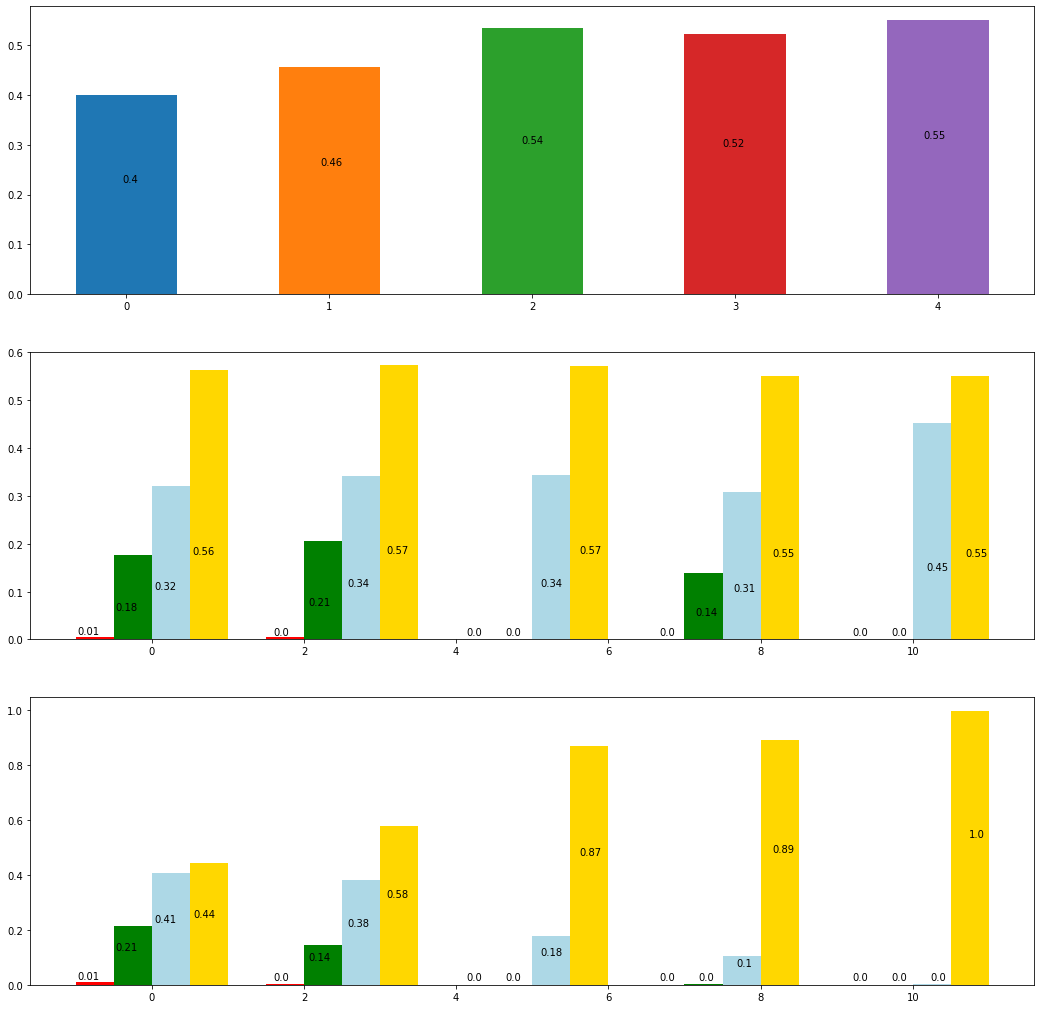

In [554]:
def apr(y_test, y_pred):
    # print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

    # print("Precision (average=None):", metrics.precision_score(y_test, y_pred, average=None))
    # print("Precision (average='micro'):", metrics.precision_score(y_test, y_pred, average='micro'))
    # print("Precision (average='macro'):", metrics.precision_score(y_test, y_pred, average='macro'))
    # print("Precision (average='weighted'):", metrics.precision_score(y_test, y_pred, average='weighted'))

    # print("Recall (average=None):", metrics.recall_score(y_test, y_pred, average=None))
    # print("Recall (average='micro'):", metrics.recall_score(y_test, y_pred, average='micro'))
    # print("Recall (average='macro'):", metrics.recall_score(y_test, y_pred, average='macro'))
    # print("Recall (average='weighted'):", metrics.recall_score(y_test, y_pred, average='weighted'))
    
    # print()
    
    return metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred, average=None), metrics.recall_score(y_test, y_pred, average=None)

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,18))
for i, y_pred in enumerate([dt_y_pred, rf_y_pred, nbc_y_pred, svm_y_pred, lr_y_pred, linreg_y_pred]):
    acc_prec_rec = apr(y_test, y_pred)

    rect = ax1.bar(i, acc_prec_rec[0], width=0.5)
    ax1.text(0.2 * i + 0.1, acc_prec_rec[0], round(acc_prec_rec[0], 2), va='center', ha='center', transform=ax1.transAxes)

    ax2.bar(i * 2.5 - 0.75, acc_prec_rec[1][0], width=0.5, color="red")
    ax2.text((10 / 52) * i + (3 / 52),
             (0.05 + acc_prec_rec[1][0]) / 2,
             round(acc_prec_rec[1][0], 2),
             va='center', ha='center', transform=ax2.transAxes)
    ax2.bar(i * 2.5 - 0.25, acc_prec_rec[1][1], width=0.5, color="green")
    ax2.text((10 / 52) * i + (5 / 52),
             (0.05 + acc_prec_rec[1][1]) / 2,
             round(acc_prec_rec[1][1], 2),
             va='center', ha='center', transform=ax2.transAxes)
    ax2.bar(i * 2.5 + 0.25, acc_prec_rec[1][2], width=0.5, color="lightblue")
    ax2.text((10 / 52) * i + (7 / 52),
             (0.05 + acc_prec_rec[1][2]) / 2,
             round(acc_prec_rec[1][2], 2),
             va='center', ha='center', transform=ax2.transAxes)
    ax2.bar(i * 2.5 + 0.75, acc_prec_rec[1][3], width=0.5, color="gold")
    ax2.text((10 / 52) * i + (9 / 52),
             (0.05 + acc_prec_rec[1][3]) / 2,
             round(acc_prec_rec[1][3], 2),
             va='center', ha='center', transform=ax2.transAxes)

    ax3.bar(i * 2.5 - 0.75, acc_prec_rec[2][0], width=0.5, color="red")
    ax3.text((10 / 52) * i + (3 / 52),
             (0.05 + acc_prec_rec[2][0]) / 2,
             round(acc_prec_rec[2][0], 2),
             va='center', ha='center', transform=ax3.transAxes)
    ax3.bar(i * 2.5 - 0.25, acc_prec_rec[2][1], width=0.5, color="green")
    ax3.text((10 / 52) * i + (5 / 52),
             (0.05 + acc_prec_rec[2][1]) / 2,
             round(acc_prec_rec[2][1], 2),
             va='center', ha='center', transform=ax3.transAxes)
    ax3.bar(i * 2.5 + 0.25, acc_prec_rec[2][2], width=0.5, color="lightblue")
    ax3.text((10 / 52) * i + (7 / 52),
             (0.05 + acc_prec_rec[2][2]) / 2,
             round(acc_prec_rec[2][2], 2),
             va='center', ha='center', transform=ax3.transAxes)
    ax3.bar(i * 2.5 + 0.75, acc_prec_rec[2][3], width=0.5, color="gold")
    ax3.text((10 / 52) * i + (9 / 52),
             (0.05 + acc_prec_rec[2][3]) / 2,
             round(acc_prec_rec[2][3], 2),
             va='center', ha='center', transform=ax3.transAxes)

ax1.legend(["DT", "RF", "NBC", "SVM", "LogReg", "LinReg"])
plt.sca(ax1)
plt.xticks([j for j in range(i)], ["DT", "RF", "NBC", "SVM", "LogReg", "LinReg"])
plt.xlabel("Classification")
plt.ylabel("Category Accuracy")

ax2.legend(["Category 1", "Category 2", "Category 3", "Category 4"])
plt.sca(ax2)
plt.xticks([j * 2.5 for j in range(i)], ["DT", "RF", "NBC", "SVM", "LogReg", "LinReg"])
plt.xlabel("Classification")
plt.ylabel("Category Precision")

ax3.legend(["Category 1", "Category 2", "Category 3", "Category 4"])
plt.sca(ax3)
plt.xticks([j * 2.5 for j in range(i)], ["DT", "RF", "NBC", "SVM", "LogReg", "LinReg"])
plt.xlabel("Classification")
plt.ylabel("Category Recall")

plt.savefig('images/Supervised_Algs/apr_categories.png')
plt.show()

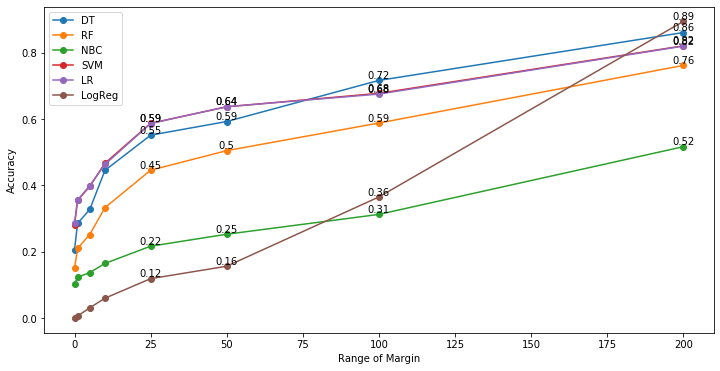

In [538]:
# Accuracy within range
def accuracy_range(y_test2, y_pred2, margin):
    return np.sum(np.absolute(y_test2 - y_pred2) <= margin) / len(y_test2)

plt.figure(figsize=(12, 6))
for y_pred2 in [dt_y_pred2, rf_y_pred2, nbc_y_pred2, svm_y_pred2, lr_y_pred2, linreg_y_pred2]:
    ar_array = [accuracy_range(y_test2, y_pred2, margin) for margin in [0, 1, 5, 10, 25, 50, 100, 200]]
    ar_array_rounded = [round(ar, 2) for ar in ar_array]
    plt.plot([0, 1, 5, 10, 25, 50, 100, 200], ar_array, linestyle='-', marker='o')
    plt.text(25, ar_array[4], ar_array_rounded[4], va='bottom', ha='center')
    plt.text(50, ar_array[5], ar_array_rounded[5], va='bottom', ha='center')
    plt.text(100, ar_array[6], ar_array_rounded[6], va='bottom', ha='center')
    plt.text(200, ar_array[7], ar_array_rounded[7], va='bottom', ha='center')

plt.legend(["DT", "RF", "NBC", "SVM", "LR", "LogReg"])
plt.xlabel("Range of Margin")
plt.ylabel("Accuracy")
plt.show()

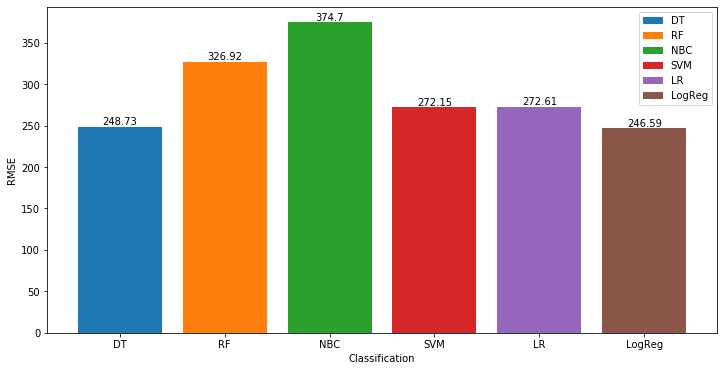

In [537]:
def rmse(pred, label):
    return np.sqrt(np.sum(np.square(np.subtract(pred, label))) / len(pred))

plt.figure(figsize=(12, 6))
for i, y_pred2 in enumerate([dt_y_pred2, rf_y_pred2, nbc_y_pred2, svm_y_pred2, lr_y_pred2, linreg_y_pred2]):
    rmse_val = rmse(y_test2, y_pred2)
    plt.bar(i, rmse_val)
    plt.text(i, rmse_val, round(rmse_val, 2), va='bottom', ha='center')

plt.legend(["DT", "RF", "NBC", "SVM", "LR", "LogReg"])
plt.xticks([0, 1, 2, 3, 4, 5], ["DT", "RF", "NBC", "SVM", "LogReg", "LinReg"])
plt.xlabel("Classification")
plt.ylabel("RMSE")
plt.show()

In [497]:
len(training_data[training_data["Crime Category"] == 4]) / len(training_data)

0.5452819114042053